## **Problem Outline**

A dataset of news stories about the detection of propaganda has been provided to us. 

Disinformation is incredibly easy to transmit in the digital age and has the potential to reach a huge audience. Propaganda attempts to change people's perceptions in order to further a specific objective. 

Data for training and testing is offered in separate files.

Utilization of extra tokens (BOS and EOS) to denote the start and end of the section of text (inside the phrase) that is actually tagged with the provided propaganda

There are total 9 classes in the propoganda detection as follows:

1. flag waving

2. appeal to fear prejudice

3. causal simplification

4. doubt

5. exaggeration,minimisation

6. loaded language

7. name calling,labeling

8. repetition

9. not propaganda
The main tasks are as follows:

1. **Build and evaluate at least 2 approaches to classify whether a sentence contains propaganda or not.**

2. **Given a snippet or span of text which is known to contain propaganda, build and evaluate at least 2 approaches to classifying the propaganda technique which has been used.**

We will use following approach in this report.

**n-grams from Word2Vec Model**: To create word embeddings, we'll utilize Word2Vec rather than GloVe. Another well-liked word representation method that may identify the semantic connections between words in a corpus is Word2Vec.


**Simple Artificial Neural Network (ANN)**: To determine if a sentence contains propaganda or not, we will build a straightforward ANN model that uses the Word2Vec embeddings of the input sentences to perform binary classification. The tagged data will be used to train the ANN, which will then learn the patterns connected to propaganda statements.

**Approach 2: Using ANN to Embed Words**

Word Embedding: In this method, the input sentences will be represented by Word2Vec or GloVe word embeddings.

**Artificial Neural Network (ANN)**: Similar to Method 1, we'll employ a straightforward ANN model to determine if a sentence contains propaganda or not based on the word embeddings.
**Method 3: LSTM Word Embedding**


**Word Embedding**: To represent the input sentences, we will utilize Word2Vec or GloVe word embeddings.

**Long Short-Term Memory (LSTM) Neural Network**: We'll utilize a normal LSTM architecture rather than a bidirectional one. The word embeddings will be used as input by the LSTM model, which will then learn to categorize whether a sentence contains propaganda or not.

**Fourth strategy: trained BERT model**

**Pretrained BERT Model**: For both span identification and propaganda technique classification tasks, we will utilize the BERT (Bidirectional Encoder Representations from Transformers) model, specifically the cased version.

BERT's fine-tuning will involve using the labeled data to perform binary classification for span identification and multi-class classification for propaganda tactic classification using the pretrained BERT model. The classes, which continue to symbolize the nine propoganda technique.

In [34]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.pyplot import xticks
from nltk.corpus import stopwords
import nltk
import re
from nltk.stem import WordNetLemmatizer
import string
from nltk.tokenize import word_tokenize
from nltk.util import ngrams
from collections import defaultdict
from tqdm import tqdm
from sklearn.model_selection import train_test_split
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
import tensorflow as tf
from sklearn.metrics import f1_score
from wordcloud import WordCloud,STOPWORDS
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.pipeline import Pipeline
from numpy import array
from numpy import asarray
from numpy import zeros
from keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense,Flatten,Embedding,Activation,Dropout
from keras.layers import Conv1D,MaxPooling1D,GlobalMaxPooling1D,LSTM

In [35]:
#Loading the Dataset
train = pd.read_csv('/content/propaganda_train.tsv',sep='\t')
val =pd.read_csv('/content/propaganda_val.tsv',sep='\t')

In [36]:
train.head()

,label,tagged_in_context
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed."
1,not_propaganda,This declassification effort <BOS> won’t make ...
2,flag_waving,The Obama administration misled the <BOS> Amer...
3,not_propaganda,“It looks like we’re capturing the demise of t...
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>"


In [37]:
val.head()

,label,tagged_in_context
0,not_propaganda,"On average, between 300 and 600 infections are..."
1,causal_oversimplification,Mostly because <BOS> the country would not las...
2,appeal_to_fear_prejudice,Lyndon Johnson <BOS> gets Earl Warren and Sen....
3,not_propaganda,<BOS> You <EOS> may opt out at anytime.
4,repetition,It must be exacted from him directly in order ...


In [38]:
#When these two lines are run, the 'target' column in the 'train' and 'val' DataFrames will show True for rows where the original 'label' was 'not_propaganda' and False for rows matching to other propaganda classes. 
train['target'] = train['label'] == 'not_propaganda'
val['target'] = val['label'] == 'not_propaganda'

In [39]:
train.head()

,label,tagged_in_context,target
0,not_propaganda,"No, <BOS> he <EOS> will not be confirmed.",True
1,not_propaganda,This declassification effort <BOS> won’t make ...,True
2,flag_waving,The Obama administration misled the <BOS> Amer...,False
3,not_propaganda,“It looks like we’re capturing the demise of t...,True
4,not_propaganda,"<BOS> Location: Westerville, Ohio <EOS>",True


In [40]:
#Dropping the label column because e have made a new column target
train = train.drop(['label'],axis=1)
val = val.drop(['label'],axis=1)

In [41]:
#label encoding will encode the labels of train and validation target classes
from sklearn import preprocessing
le = preprocessing.LabelEncoder()
train['target'] = le.fit_transform(train['target'])
val['target'] = le.fit_transform(val['target'])

In [42]:
train.head()

,tagged_in_context,target
0,"No, <BOS> he <EOS> will not be confirmed.",1
1,This declassification effort <BOS> won’t make ...,1
2,The Obama administration misled the <BOS> Amer...,0
3,“It looks like we’re capturing the demise of t...,1
4,"<BOS> Location: Westerville, Ohio <EOS>",1


In [43]:
#This will change the name of column
train.rename(columns = {'tagged_in_context':'data'}, inplace = True)
val.rename(columns = {'tagged_in_context':'data'}, inplace = True)

In [44]:
train.head()

,data,target
0,"No, <BOS> he <EOS> will not be confirmed.",1
1,This declassification effort <BOS> won’t make ...,1
2,The Obama administration misled the <BOS> Amer...,0
3,“It looks like we’re capturing the demise of t...,1
4,"<BOS> Location: Westerville, Ohio <EOS>",1


In [45]:
#This will drop duplicates values in the column.
train = train.drop_duplicates(subset=["data"], keep="first")
val = val.drop_duplicates(subset=["data"], keep="first")

In [46]:
train.isnull().sum().sort_values(ascending = False)

data      0
target    0
dtype: int64

In [47]:
val.isnull().sum().sort_values(ascending = False)

data      0
target    0
dtype: int64

In [48]:
# function to draw bar plot of target column
def draw_bar_plot(category,length,xlabel,ylabel,title,sub):
    plt.subplot(2,2,sub)
    plt.bar(category, length)
    plt.legend()
    plt.xlabel(xlabel, fontsize=15)
    plt.ylabel(ylabel, fontsize=15)
    plt.title(title, fontsize=15)
    #plt.show()

In [49]:
# function to draw histogram o features
def draw_hist(xlabel, ylabel,title,target,sub,color):
    plt.subplot(1,2,sub)
    plt.hist(train[train.target==target]["length"],color = color)
    plt.title(title,fontsize=25)
    plt.xlabel(xlabel,fontsize=15)
    plt.ylabel(ylabel,fontsize=15)
    plt.ylim(0,1200)
    plt.grid()

In [50]:
# function to draw graphs for stopwords and punctuations,this function will show the stopwards and punc.
def draw_bar_n_plot(data,title):
# lets visualize the top 10 stop words
    x,y=zip(*data)

    plt.figure(figsize = (25,10))
    plt.subplot(1,2,1)
    plt.bar(x,y)
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

    plt.subplot(1,2,2)
    plt.plot(x,y,'g')
    plt.title("Top 10 "+ title,fontsize=25)
    plt.xlabel(title,fontsize=15)
    plt.ylabel("Count",fontsize=15)
    plt.grid()

In [51]:
print("No. of propoganda (Target = 1):",len(train[train["target"]==1]))
print("No. of not propoganda (Target = 0):",len(train[train["target"]==0]))
print("No. of propoganda (Target = 1):",len(val[val["target"]==1]))
print("No. of not propoganda (Target = 0):",len(val[val["target"]==0]))

No. of propoganda (Target = 1): 1186
No. of not propoganda (Target = 0): 1216
No. of propoganda (Target = 1): 301
No. of not propoganda (Target = 0): 279


<Axes: >

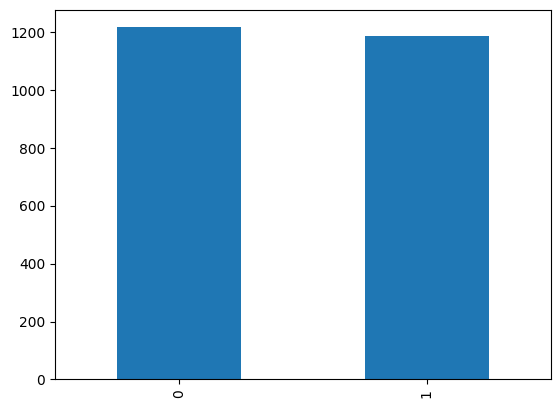

In [69]:
train["target"].value_counts().plot(kind="bar")

In [70]:
#This function will return the length of data/text
def length(data):
    return len(data)

train["length"]= train.data.apply(length)


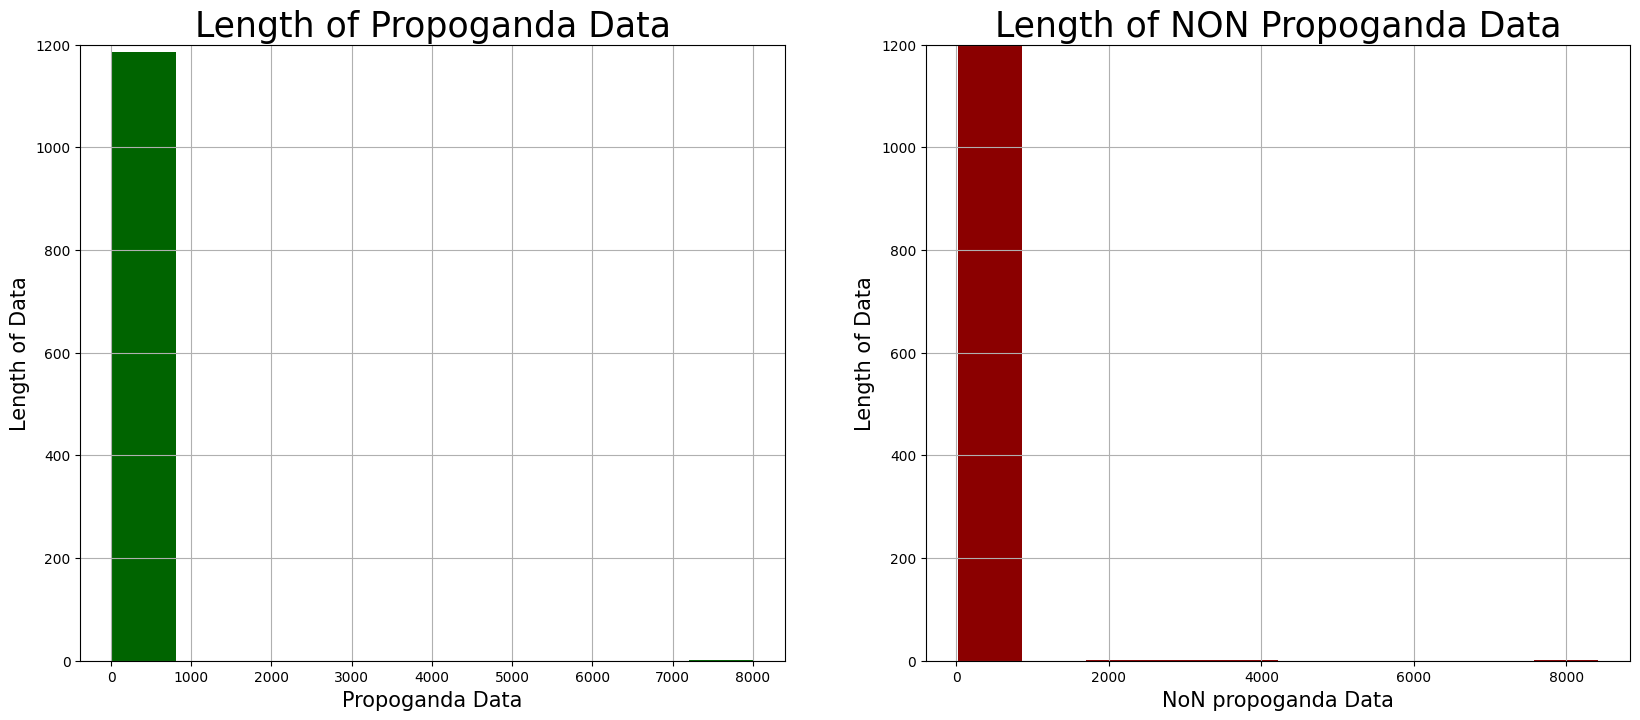

In [71]:
plt.figure(figsize = (20,8))
draw_hist("Propoganda Data","Length of Data","Length of Propoganda Data",1, 1,"darkgreen")
draw_hist("NoN propoganda Data","Length of Data","Length of NON Propoganda Data",0, 2,"darkred")

In [72]:
print(train.groupby("target").mean()["length"].sort_values(ascending = False))

target
0    207.046053
1    145.569140
Name: length, dtype: float64


<ipython-input-72-362b5715199a>:1: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  print(train.groupby("target").mean()["length"].sort_values(ascending = False))


In [74]:
#Natural language toolkit(downloding stopwords)
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [75]:
stop = list(stopwords.words("english"))#list of stopwords

In [77]:
#This is just finding the top 10 stopwords in dataset through nltk 
sw = []
for message in train.data:
    for word in message.split():
        if word in stop:
            sw.append(word)

wordlist = nltk.FreqDist(sw)
top10 = wordlist.most_common(10)

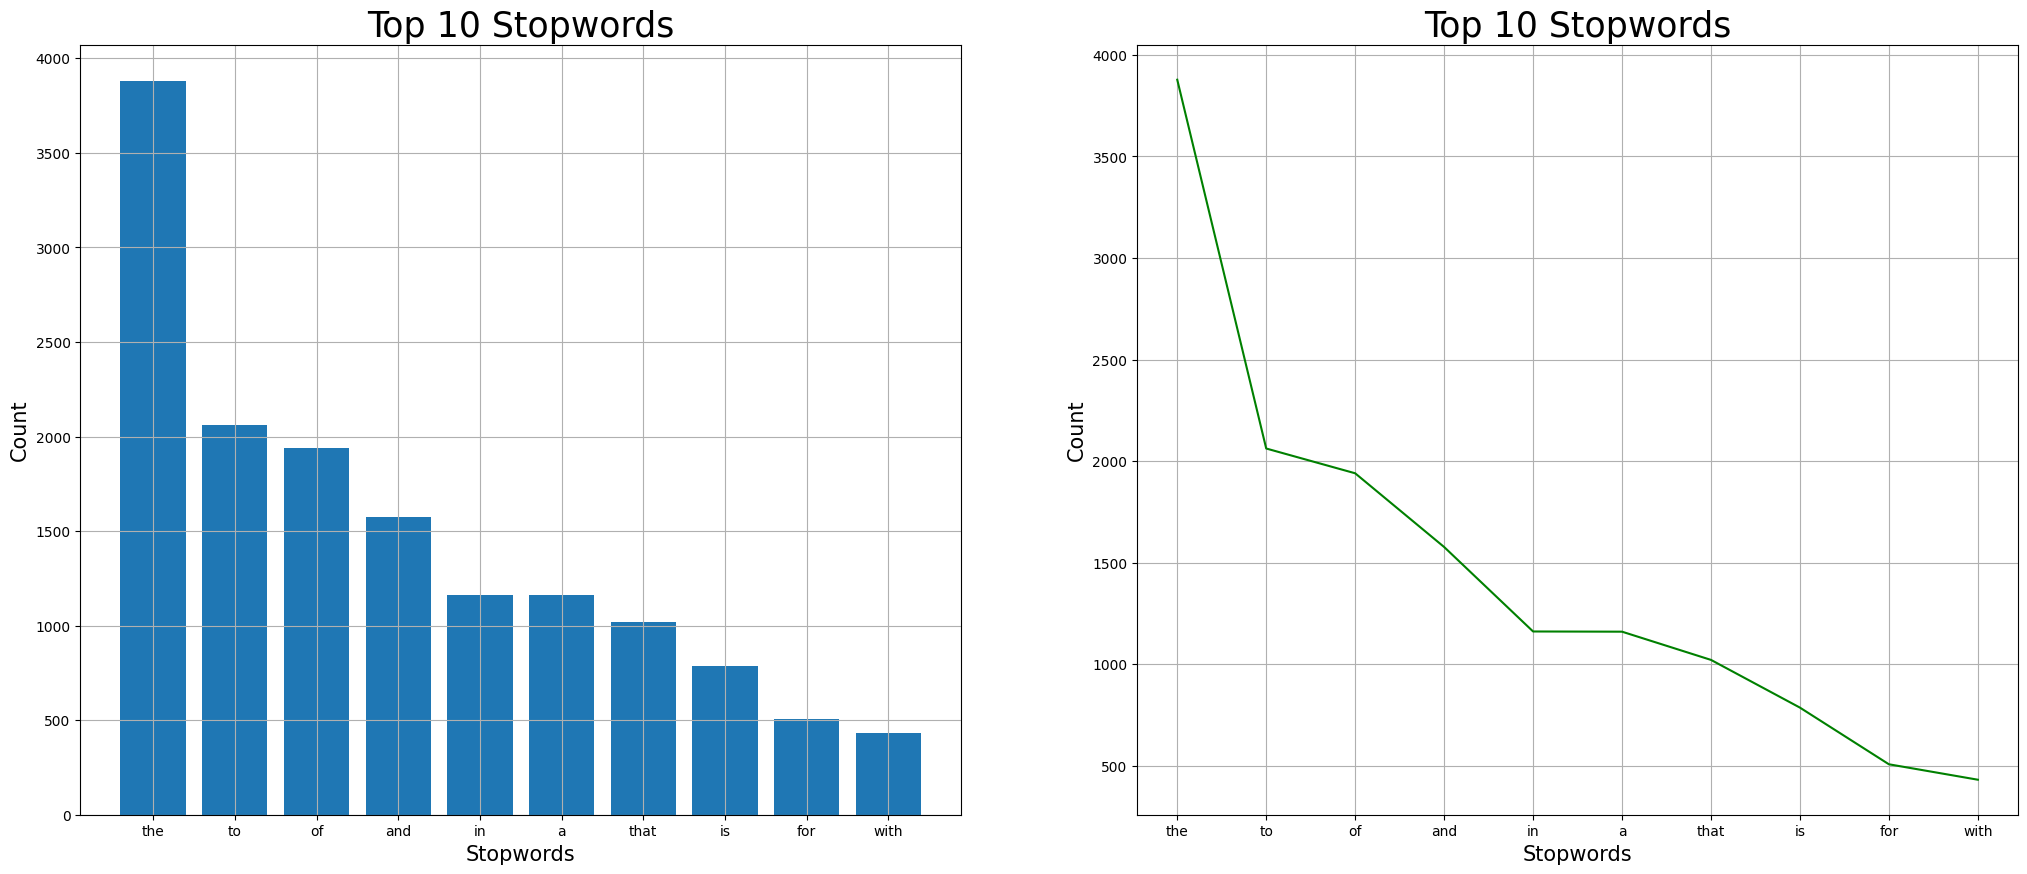

In [78]:
draw_bar_n_plot(top10,"Stopwords")

In [79]:
punctuation = list(string.punctuation)

In [81]:
#This is just finding the top 10 punctuation in dataset through nltk 
pun = []
for message in train.data:
    for word in message.split():
        if word in punctuation:
            pun.append(word)
wordlist = nltk.FreqDist(pun)
top10 = wordlist.most_common(10)

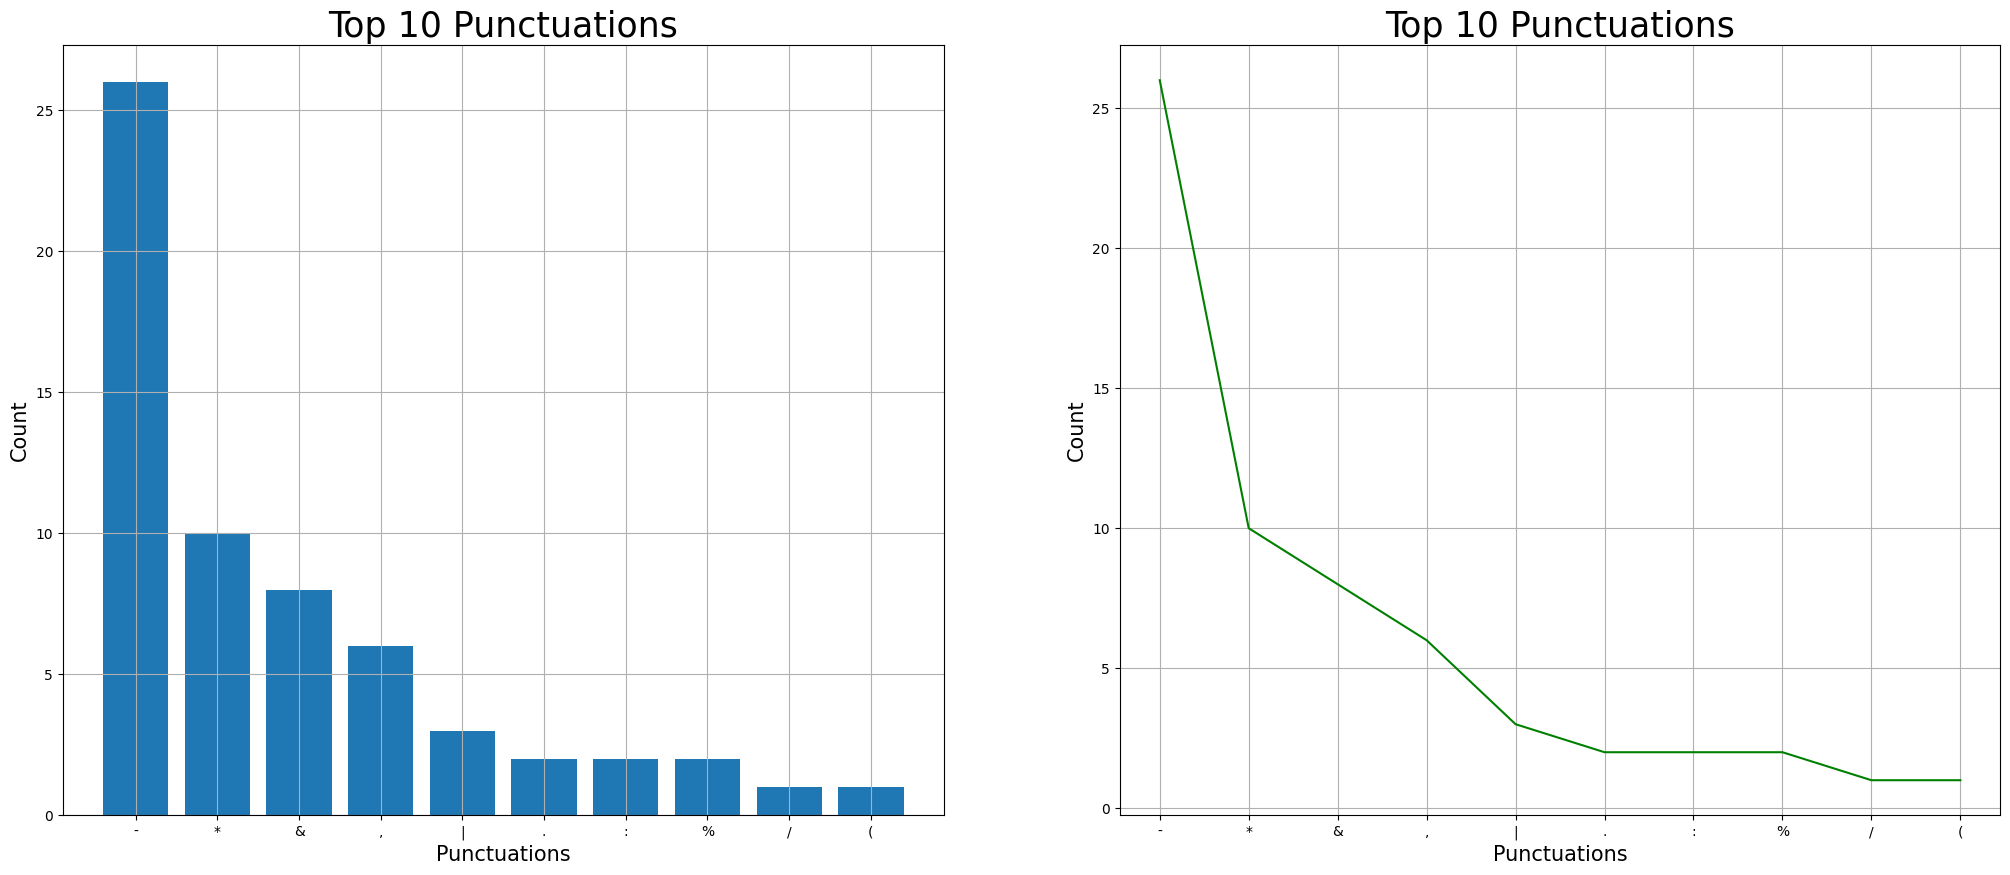

In [82]:
draw_bar_n_plot(top10,"Punctuations")

In [87]:
stop_prop = []
pun_prop  = []
for message in train[train.target==1]["data"]:
    for word in message.split():
        if word in stop:
            stop_prop.append(word)
        if word in punctuation:
            pun_prop.append(word)


stop_prop_wordlist = nltk.FreqDist(stop_prop)
pun_prop_wordlist =  nltk.FreqDist(pun_prop)

# lets save the 10 most frequent stopwords
stop_prop_top10 = stop_prop_wordlist.most_common(10)
pun_prop_top10  = pun_prop_wordlist.most_common(10)

In [88]:
stop_non_prop = []
pun_non_prop  = []
for message in train[train.target==0]["data"]:
    for word in message.split():
        if word in stop:
            stop_non_prop.append(word)
        if word in punctuation:
            pun_non_prop.append(word)


# lets convert the list to a dictinoary which would contain the stop word and its frequency
stop_non_prop_wordlist = nltk.FreqDist(stop_non_prop)
pun_non_prop_wordlist =  nltk.FreqDist(pun_non_prop)

# lets save the 10 most frequent stopwords
stop_non_prop_top10 = stop_non_prop_wordlist.most_common(10)
pun_non_prop_top10  = pun_non_prop_wordlist.most_common(10)


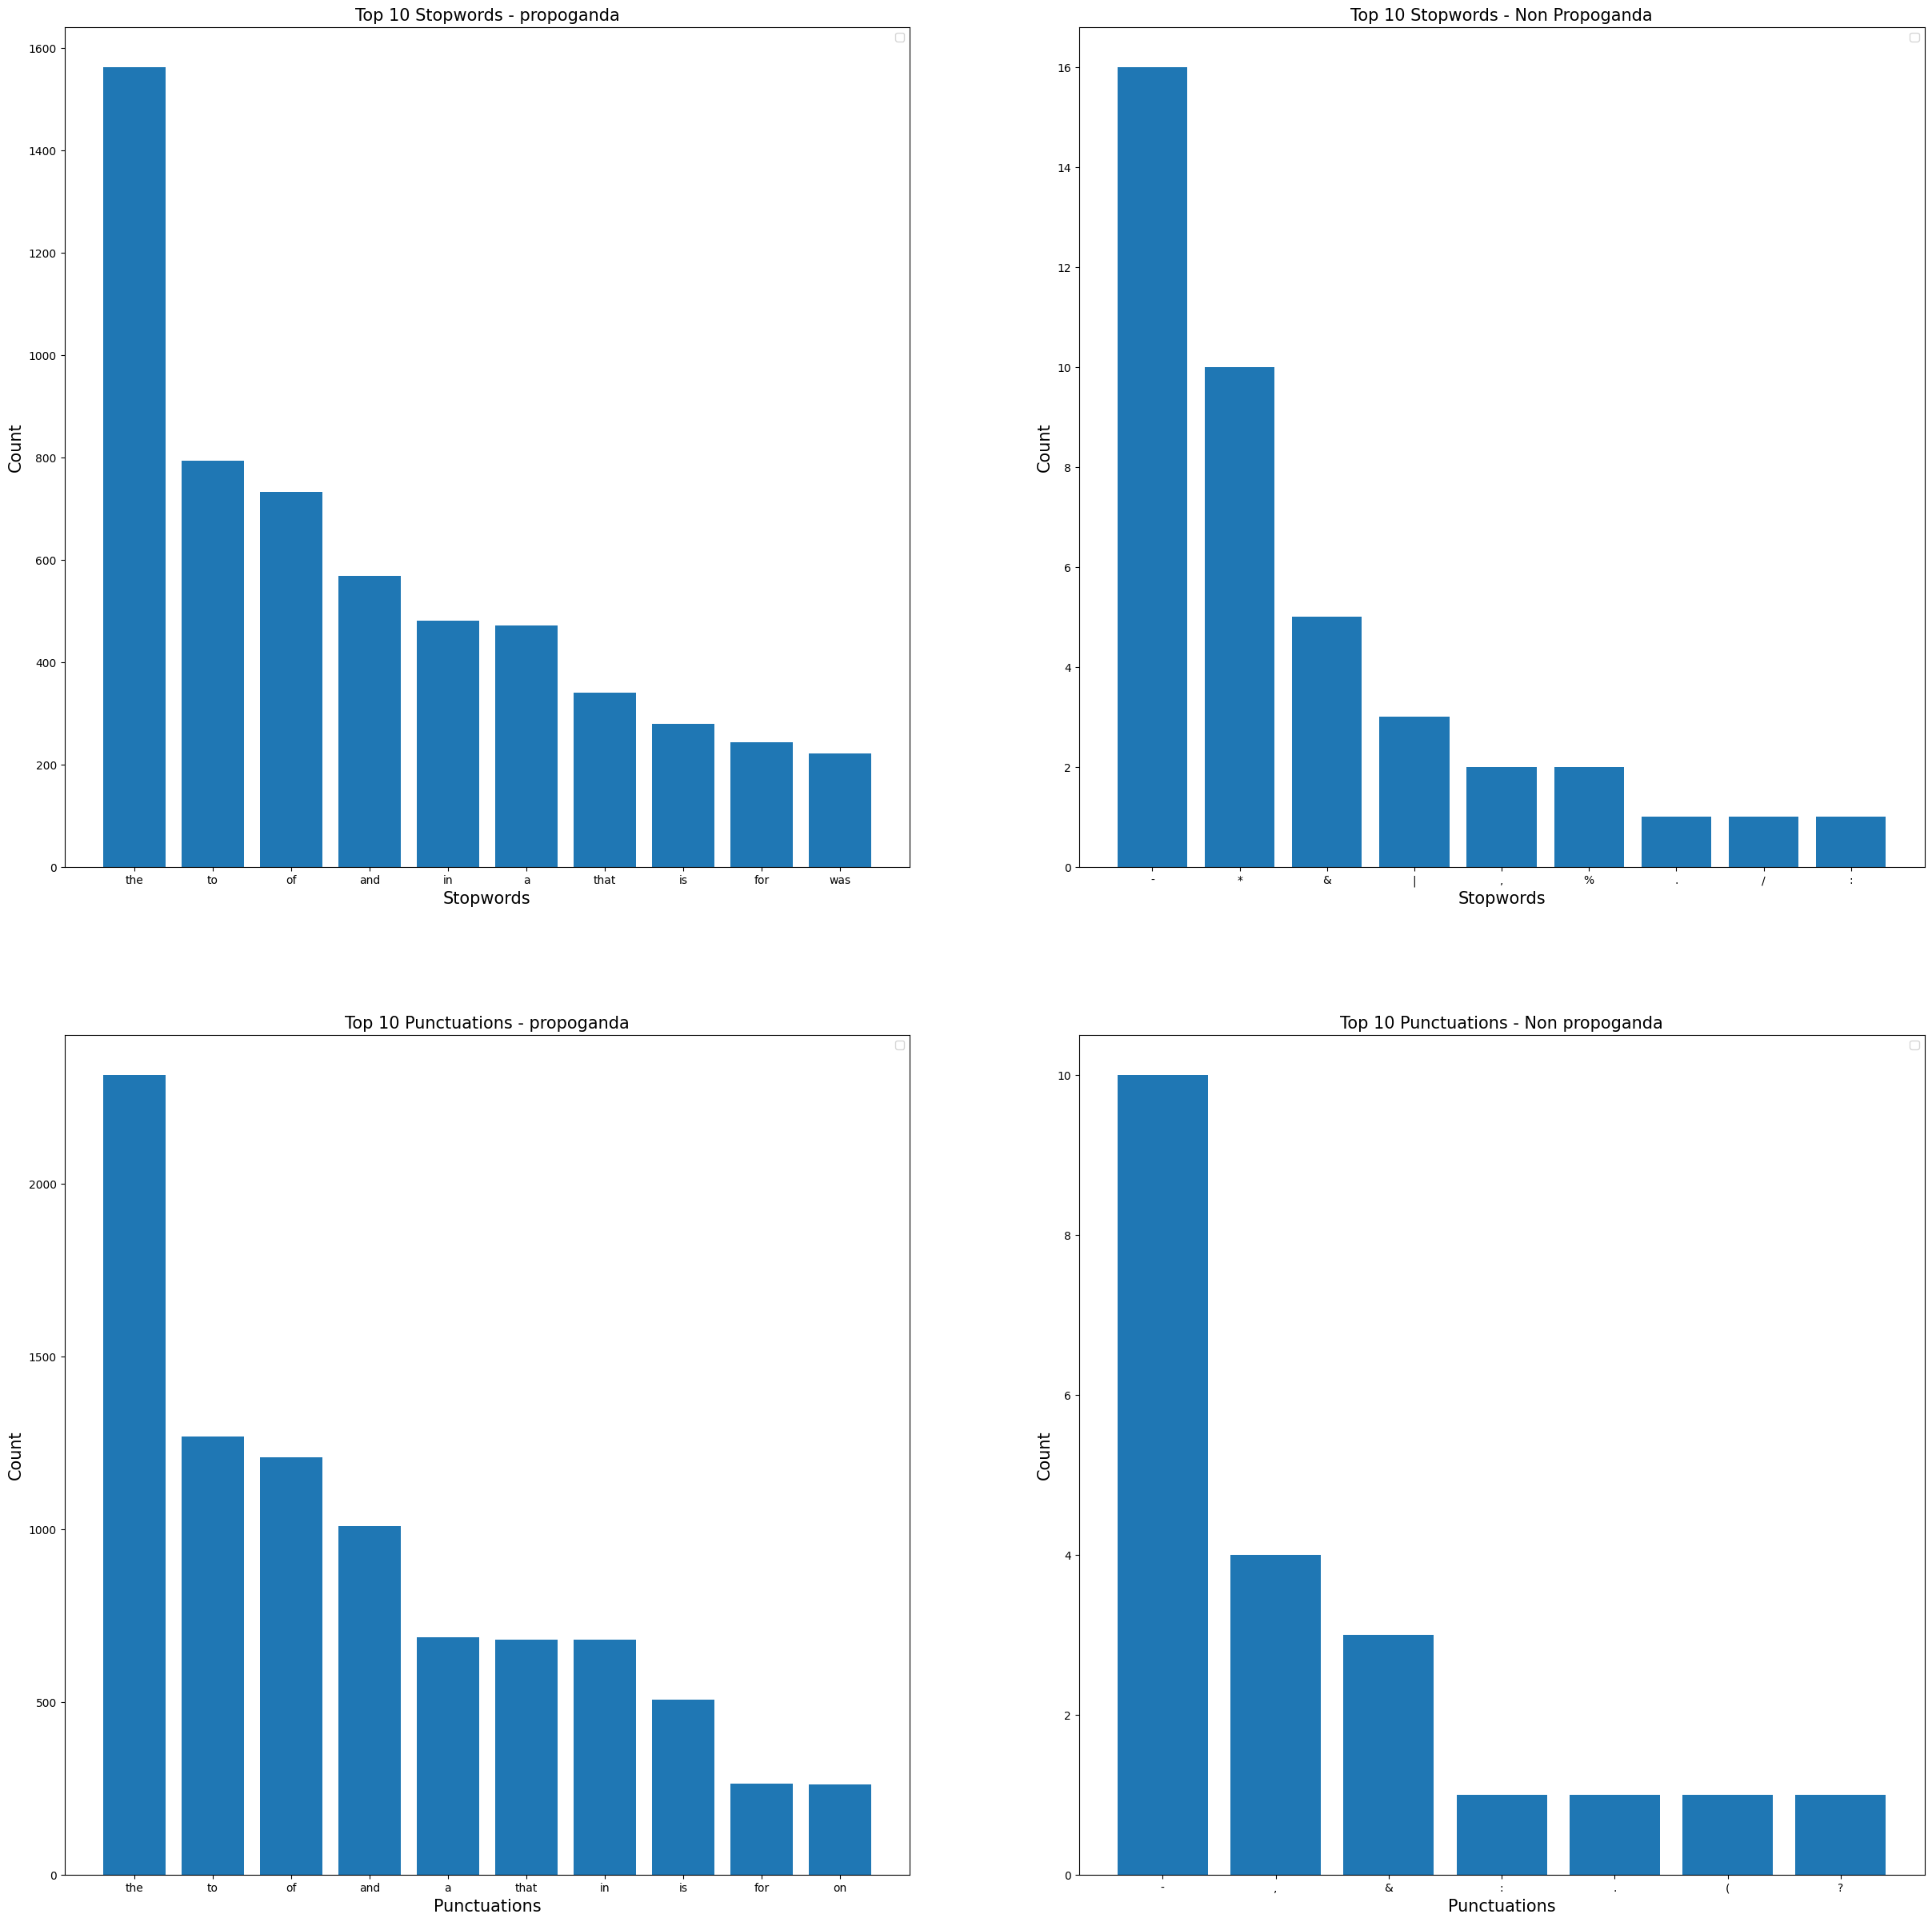

In [90]:
x_stop_prop,y_stop_prop=zip(*stop_prop_top10)
x_pun_prop, y_pun_prop =zip(*pun_prop_top10)

x_stop_non_prop,y_stop_non_prop=zip(*stop_non_prop_top10)
x_pun_non_prop, y_pun_non_prop=zip(*pun_non_prop_top10)


plt.figure(figsize = (30,30))
draw_bar_plot(x_stop_prop,y_stop_prop,"Stopwords","Count","Top 10 Stopwords - propoganda",1)
draw_bar_plot(x_pun_prop,y_pun_prop,"Stopwords","Count","Top 10 Stopwords - Non Propoganda",2)
draw_bar_plot(x_stop_non_prop,y_stop_non_prop,"Punctuations","Count","Top 10 Punctuations - propoganda",3)
draw_bar_plot(x_pun_non_prop,y_pun_non_prop,"Punctuations","Count","Top 10 Punctuations - Non propoganda",4)

In [91]:
lemma = WordNetLemmatizer()

In [92]:
sw_pun = stop + punctuation

In [93]:
def preprocess(text):
    text = re.sub(r"https?:\/\/t.co\/[A-Za-z0-9]+", "", text) # removing urls
    text = re.sub('[^\w]',' ',text)
    text = re.sub('[\d]','',text) # this will remove numeric characters
    text = re.sub('[<BOS>(.+?)<EOS>]','',text)#will remove starting and ending tags/if you donot want
    text = text.lower()#will convert text into lower 
    words = text.split()
    sentence = ""
    for word in words:
        if word not in (sw_pun):  # removing stopwords & punctuations
            word = lemma.lemmatize(word,pos = 'v')  # converting to lemma
            if len(word) > 3: # we will consider words with length  greater than 3 only
                sentence = sentence + word + ' '
    return(sentence)

In [96]:
import nltk
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to /root/nltk_data...


True

In [97]:
train['data'] = train['data'].apply(lambda s : preprocess(s))

In [98]:
def remove_emoji(text):
    emoji_pattern = re.compile("["
                           u"\U0001F600-\U0001F64F"  # emoticons
                           u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                           u"\U0001F680-\U0001F6FF"  # transport & map symbols
                           u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                           u"\U00002702-\U000027B0"
                           u"\U000024C2-\U0001F251"
                           "]+", flags=re.UNICODE)
    return emoji_pattern.sub(r'', text)

In [99]:
train['data'] = train['data'].apply(lambda s : remove_emoji(s))

In [104]:
propoganda = train[train.target==1].reset_index()
not_propoganda = train[train.target==0].reset_index()

In [108]:
#This function will show /get ngrams
def get_ngrams(data,n):
    all_words = []
    for i in range(len(data)):
        temp = data["data"][i].split()
        for word in temp:
            all_words.append(word)

    tokenized = all_words
    esBigrams = ngrams(tokenized, n)

    esBigram_wordlist = nltk.FreqDist(esBigrams)
    top100 = esBigram_wordlist.most_common(100)
    top100 = dict(top100)
    df_ngrams = pd.DataFrame(sorted(top100.items(), key=lambda x: x[1])[::-1])
    return df_ngrams

In [109]:
def draw_barplots(prop,non_prop,title):
    plt.figure(figsize = (40,80),dpi=100)

    plt.subplot(1,2,1)
    sns.barplot(y=prop[0].values[:100], x=prop[1].values[:100], color='green')
    plt.title("Top 100" + title + "in Propoganda",fontsize=15)

    plt.subplot(1,2,2)
    sns.barplot(y=non_prop[0].values[:100], x=non_prop[1].values[:100],color='red')
    plt.title("Top 100" + title + "in Non Propoganda",fontsize=15)

In [110]:
propoganda_unigrams = get_ngrams(propoganda,1)
non_propognda_unigrams = get_ngrams(not_propoganda,1)

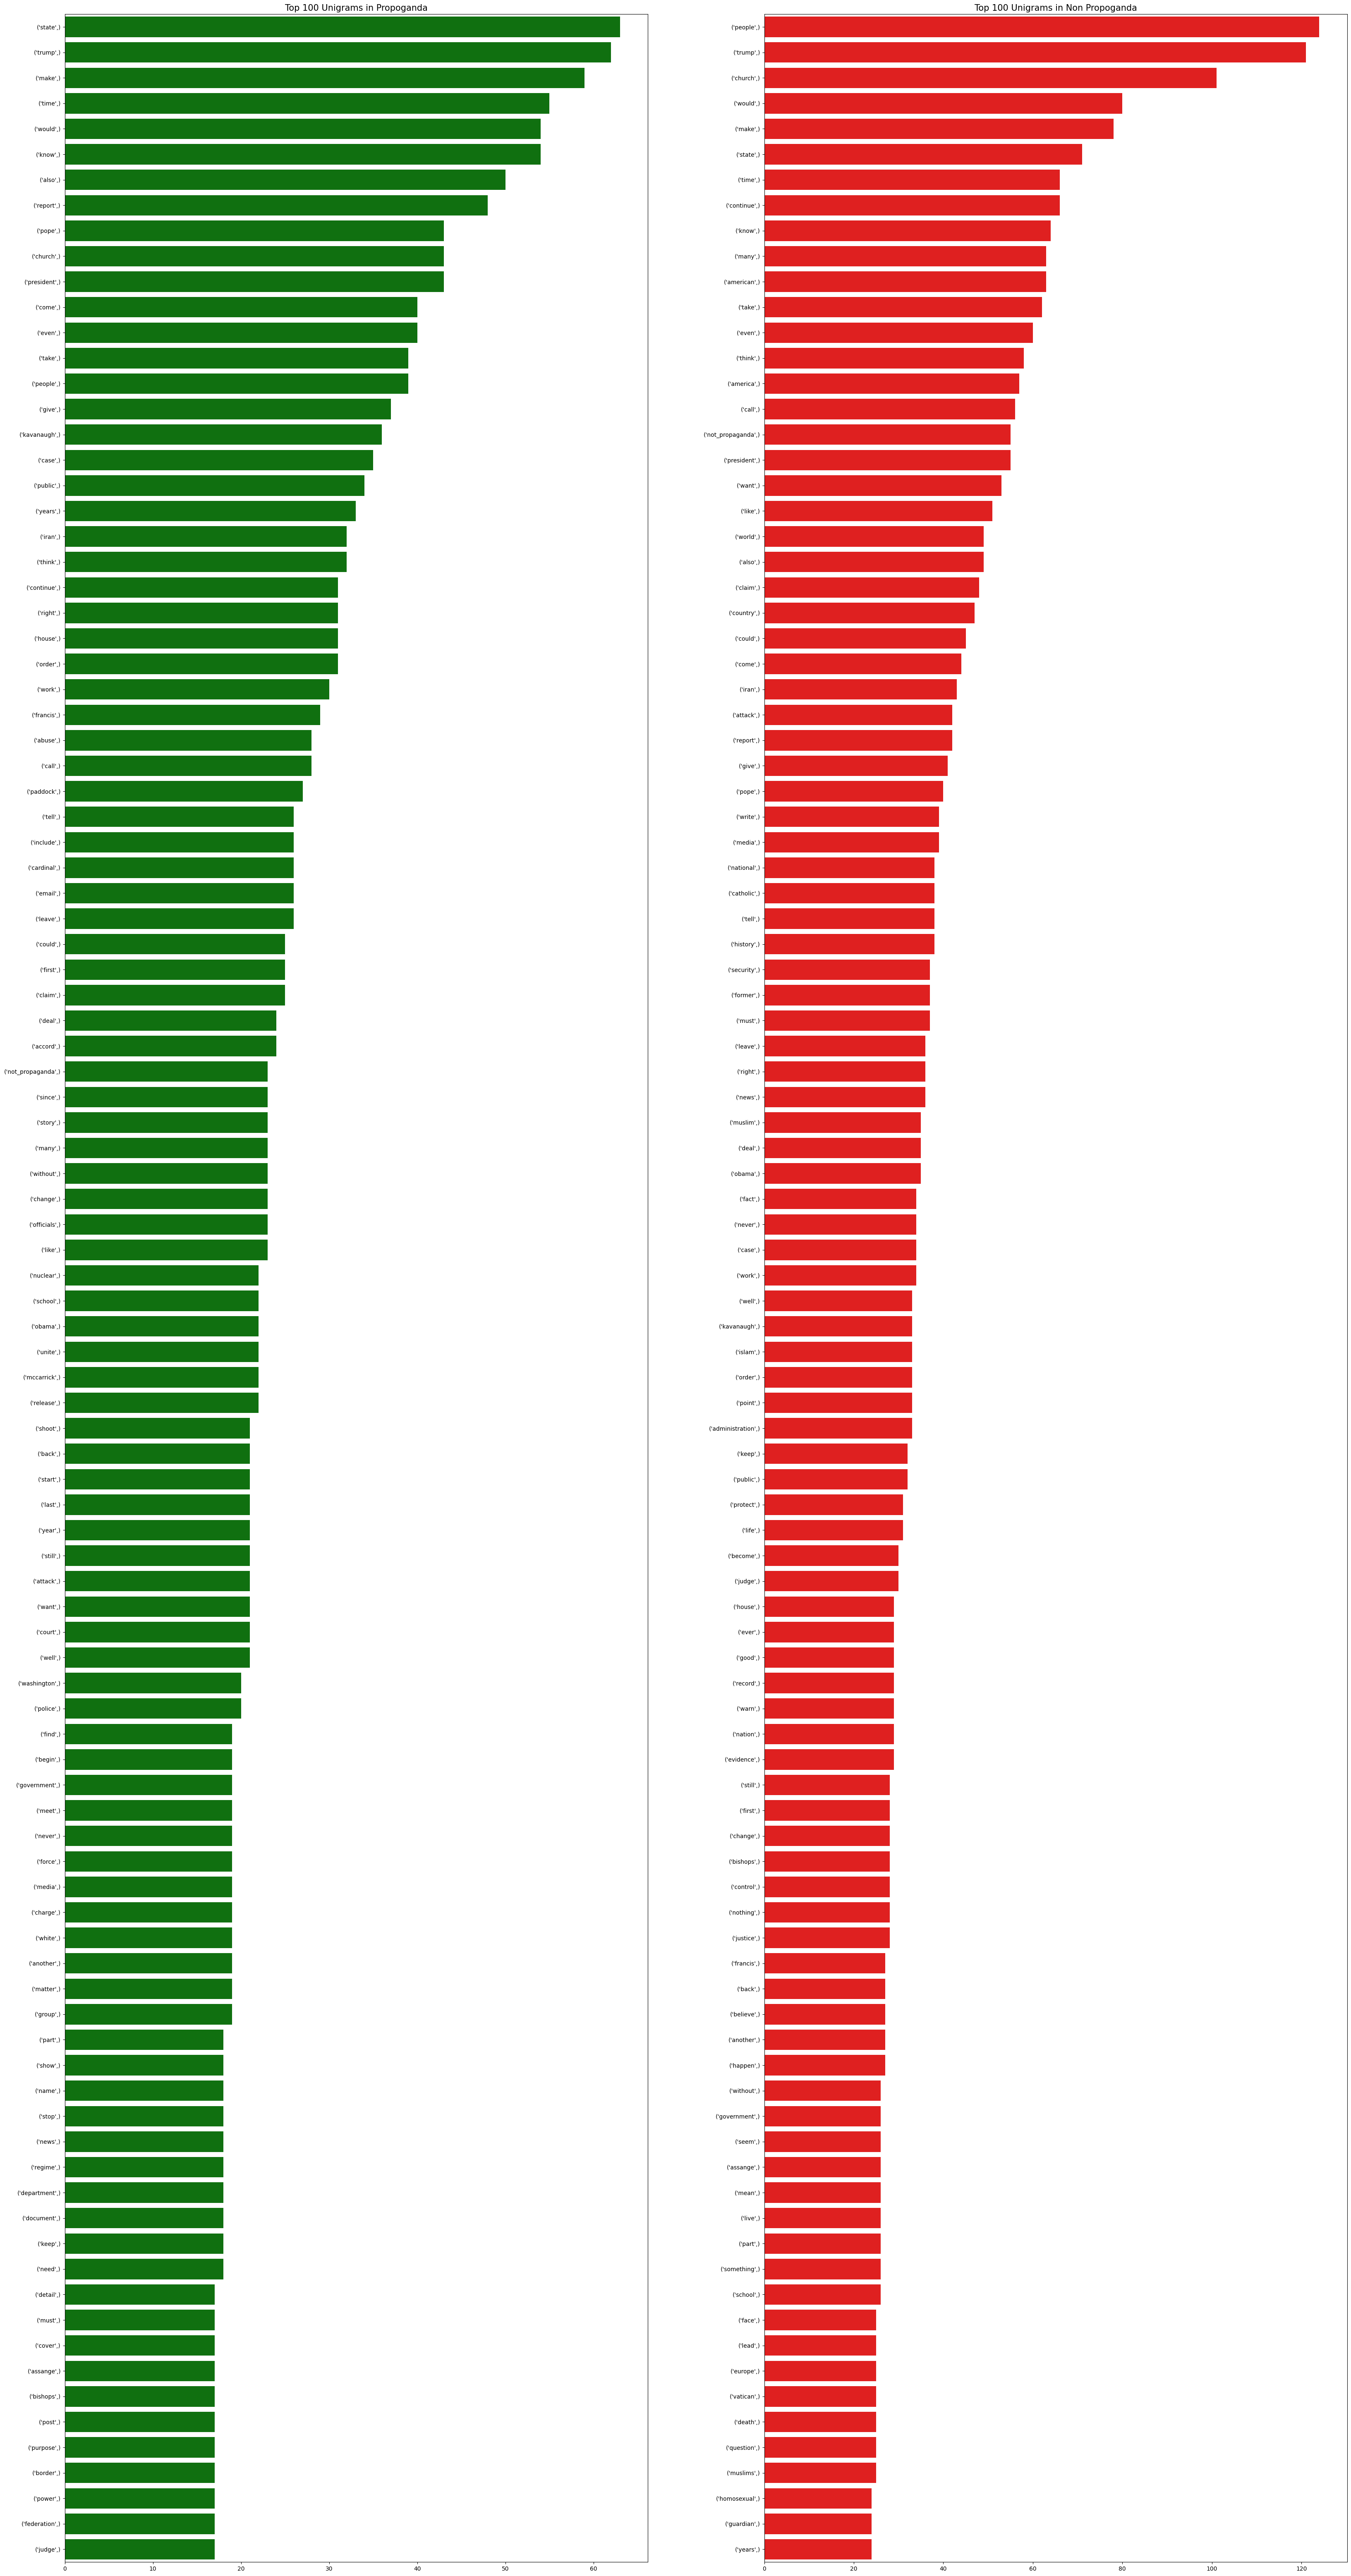

In [111]:
draw_barplots(propoganda_unigrams,non_propognda_unigrams," Unigrams ")

In [112]:
propoganda_bigrams = get_ngrams(propoganda,2)
non_propoganda_bigrams = get_ngrams(not_propoganda,2)

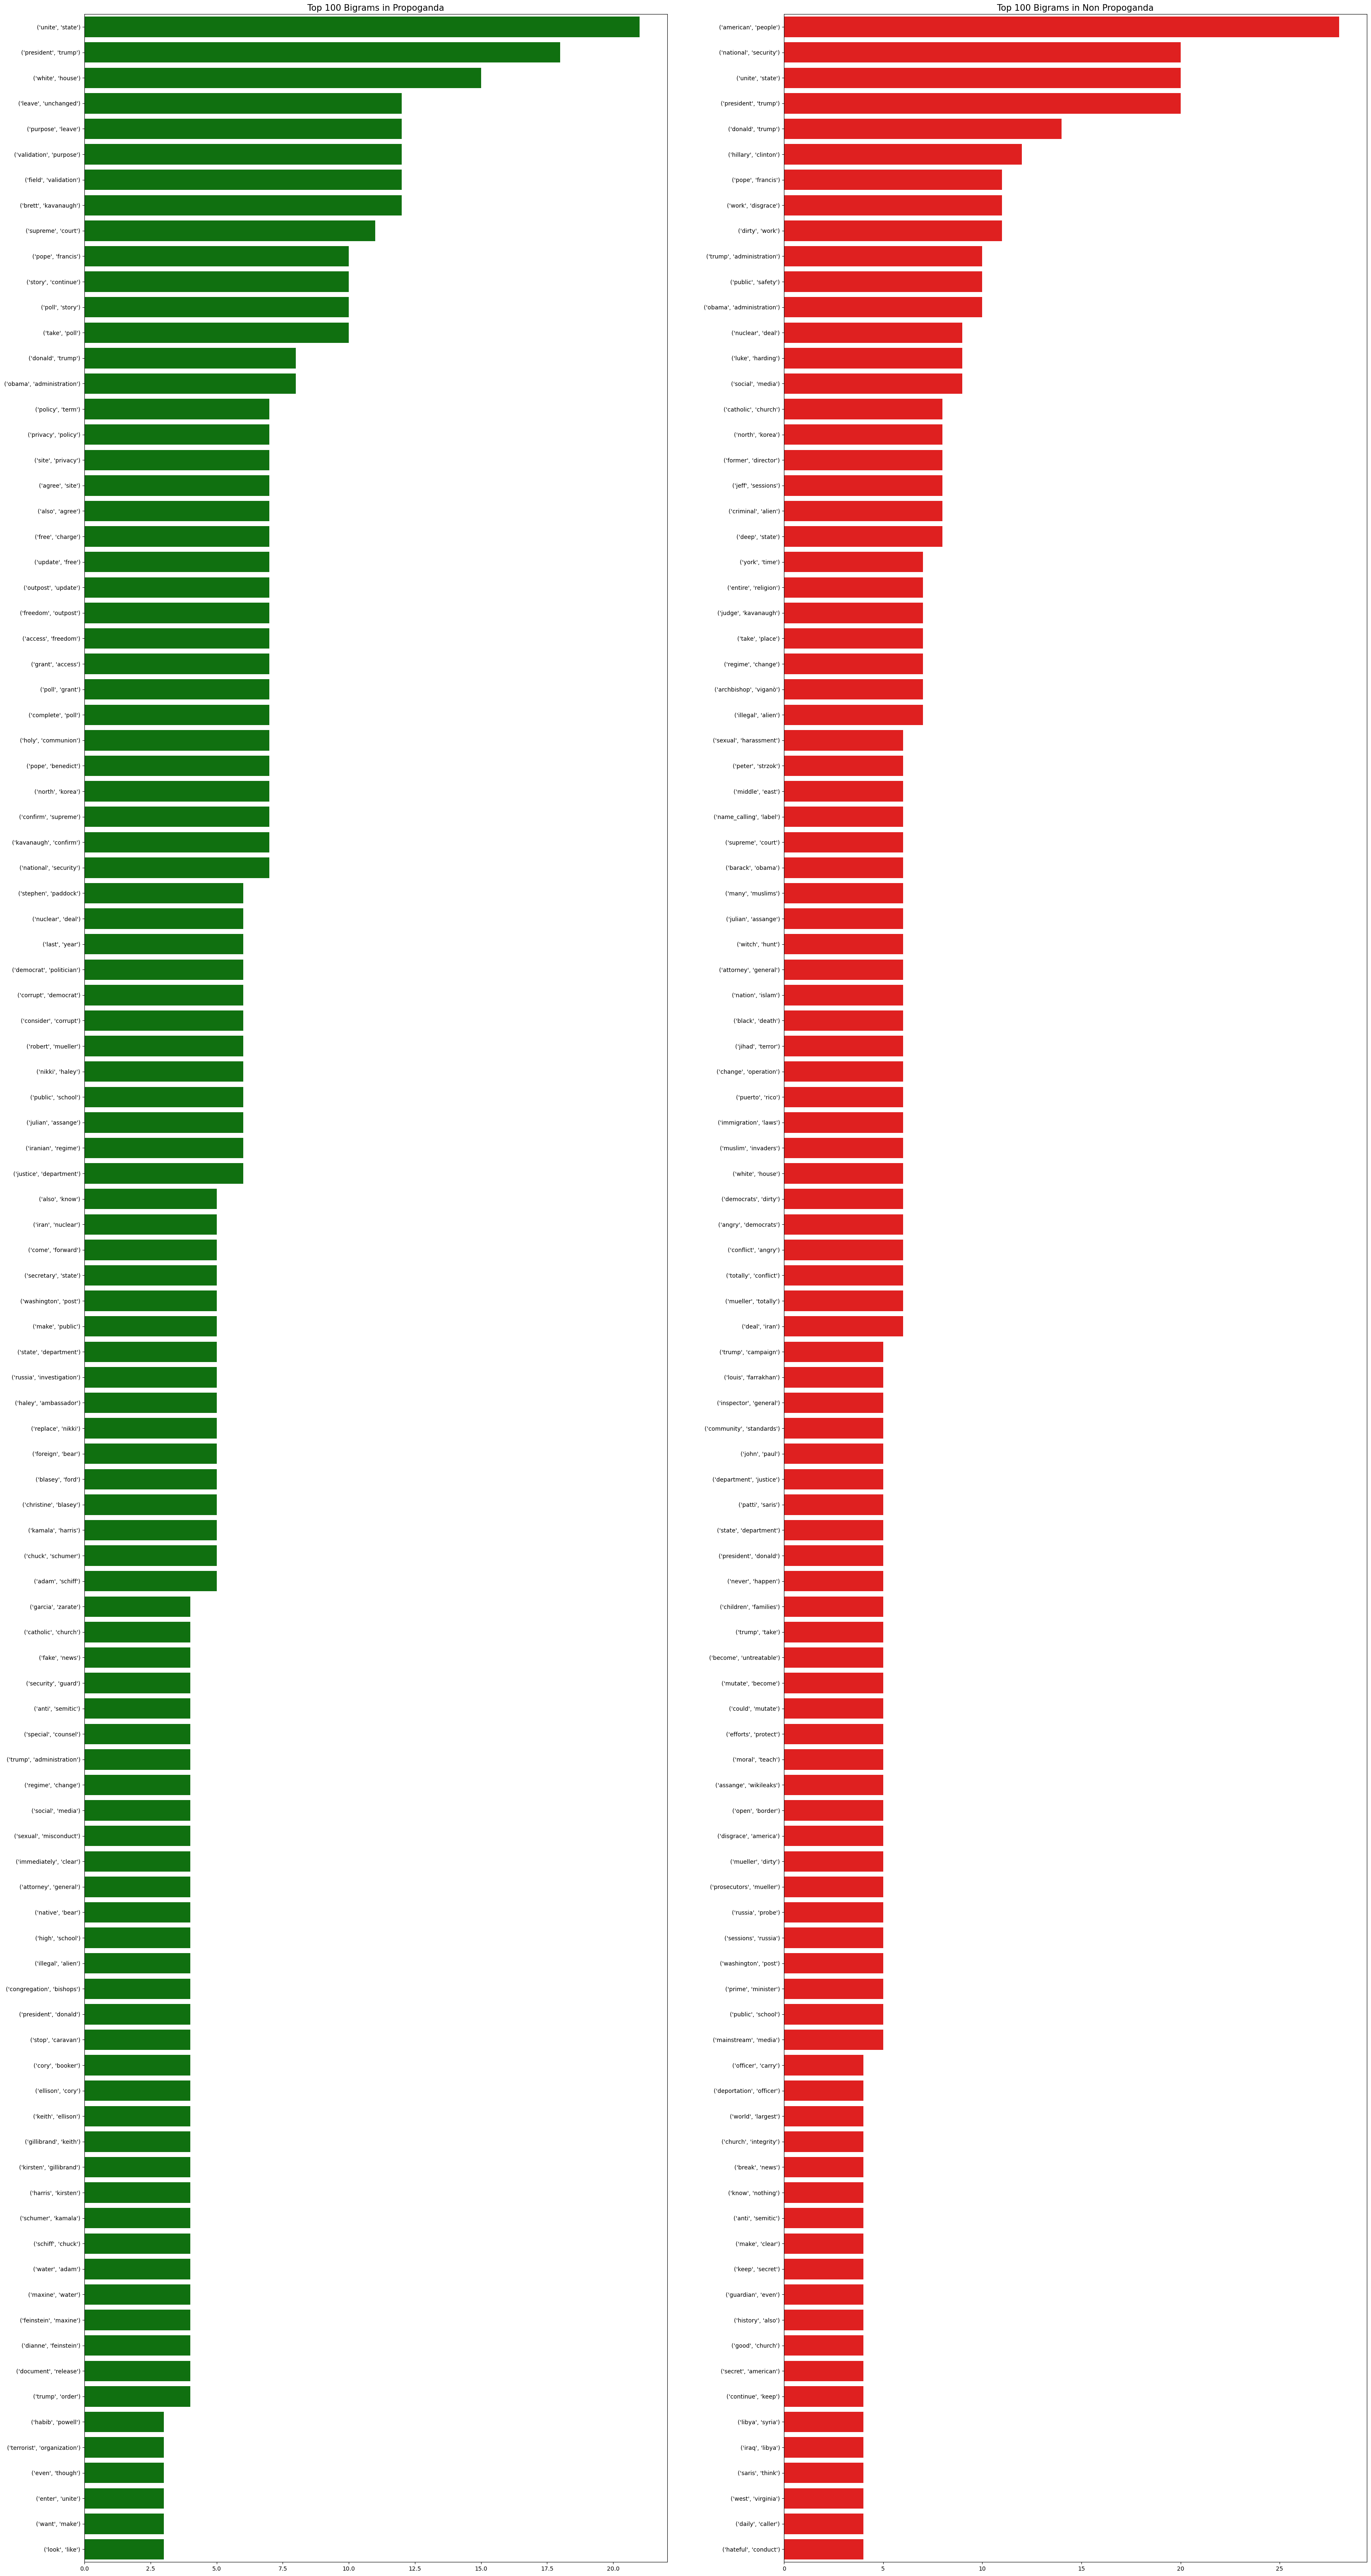

In [113]:
draw_barplots(propoganda_bigrams,non_propoganda_bigrams," Bigrams ")

In [114]:
propoganda_trigrams = get_ngrams(propoganda,3)
non_propoganda_trigrams = get_ngrams(not_propoganda,3)

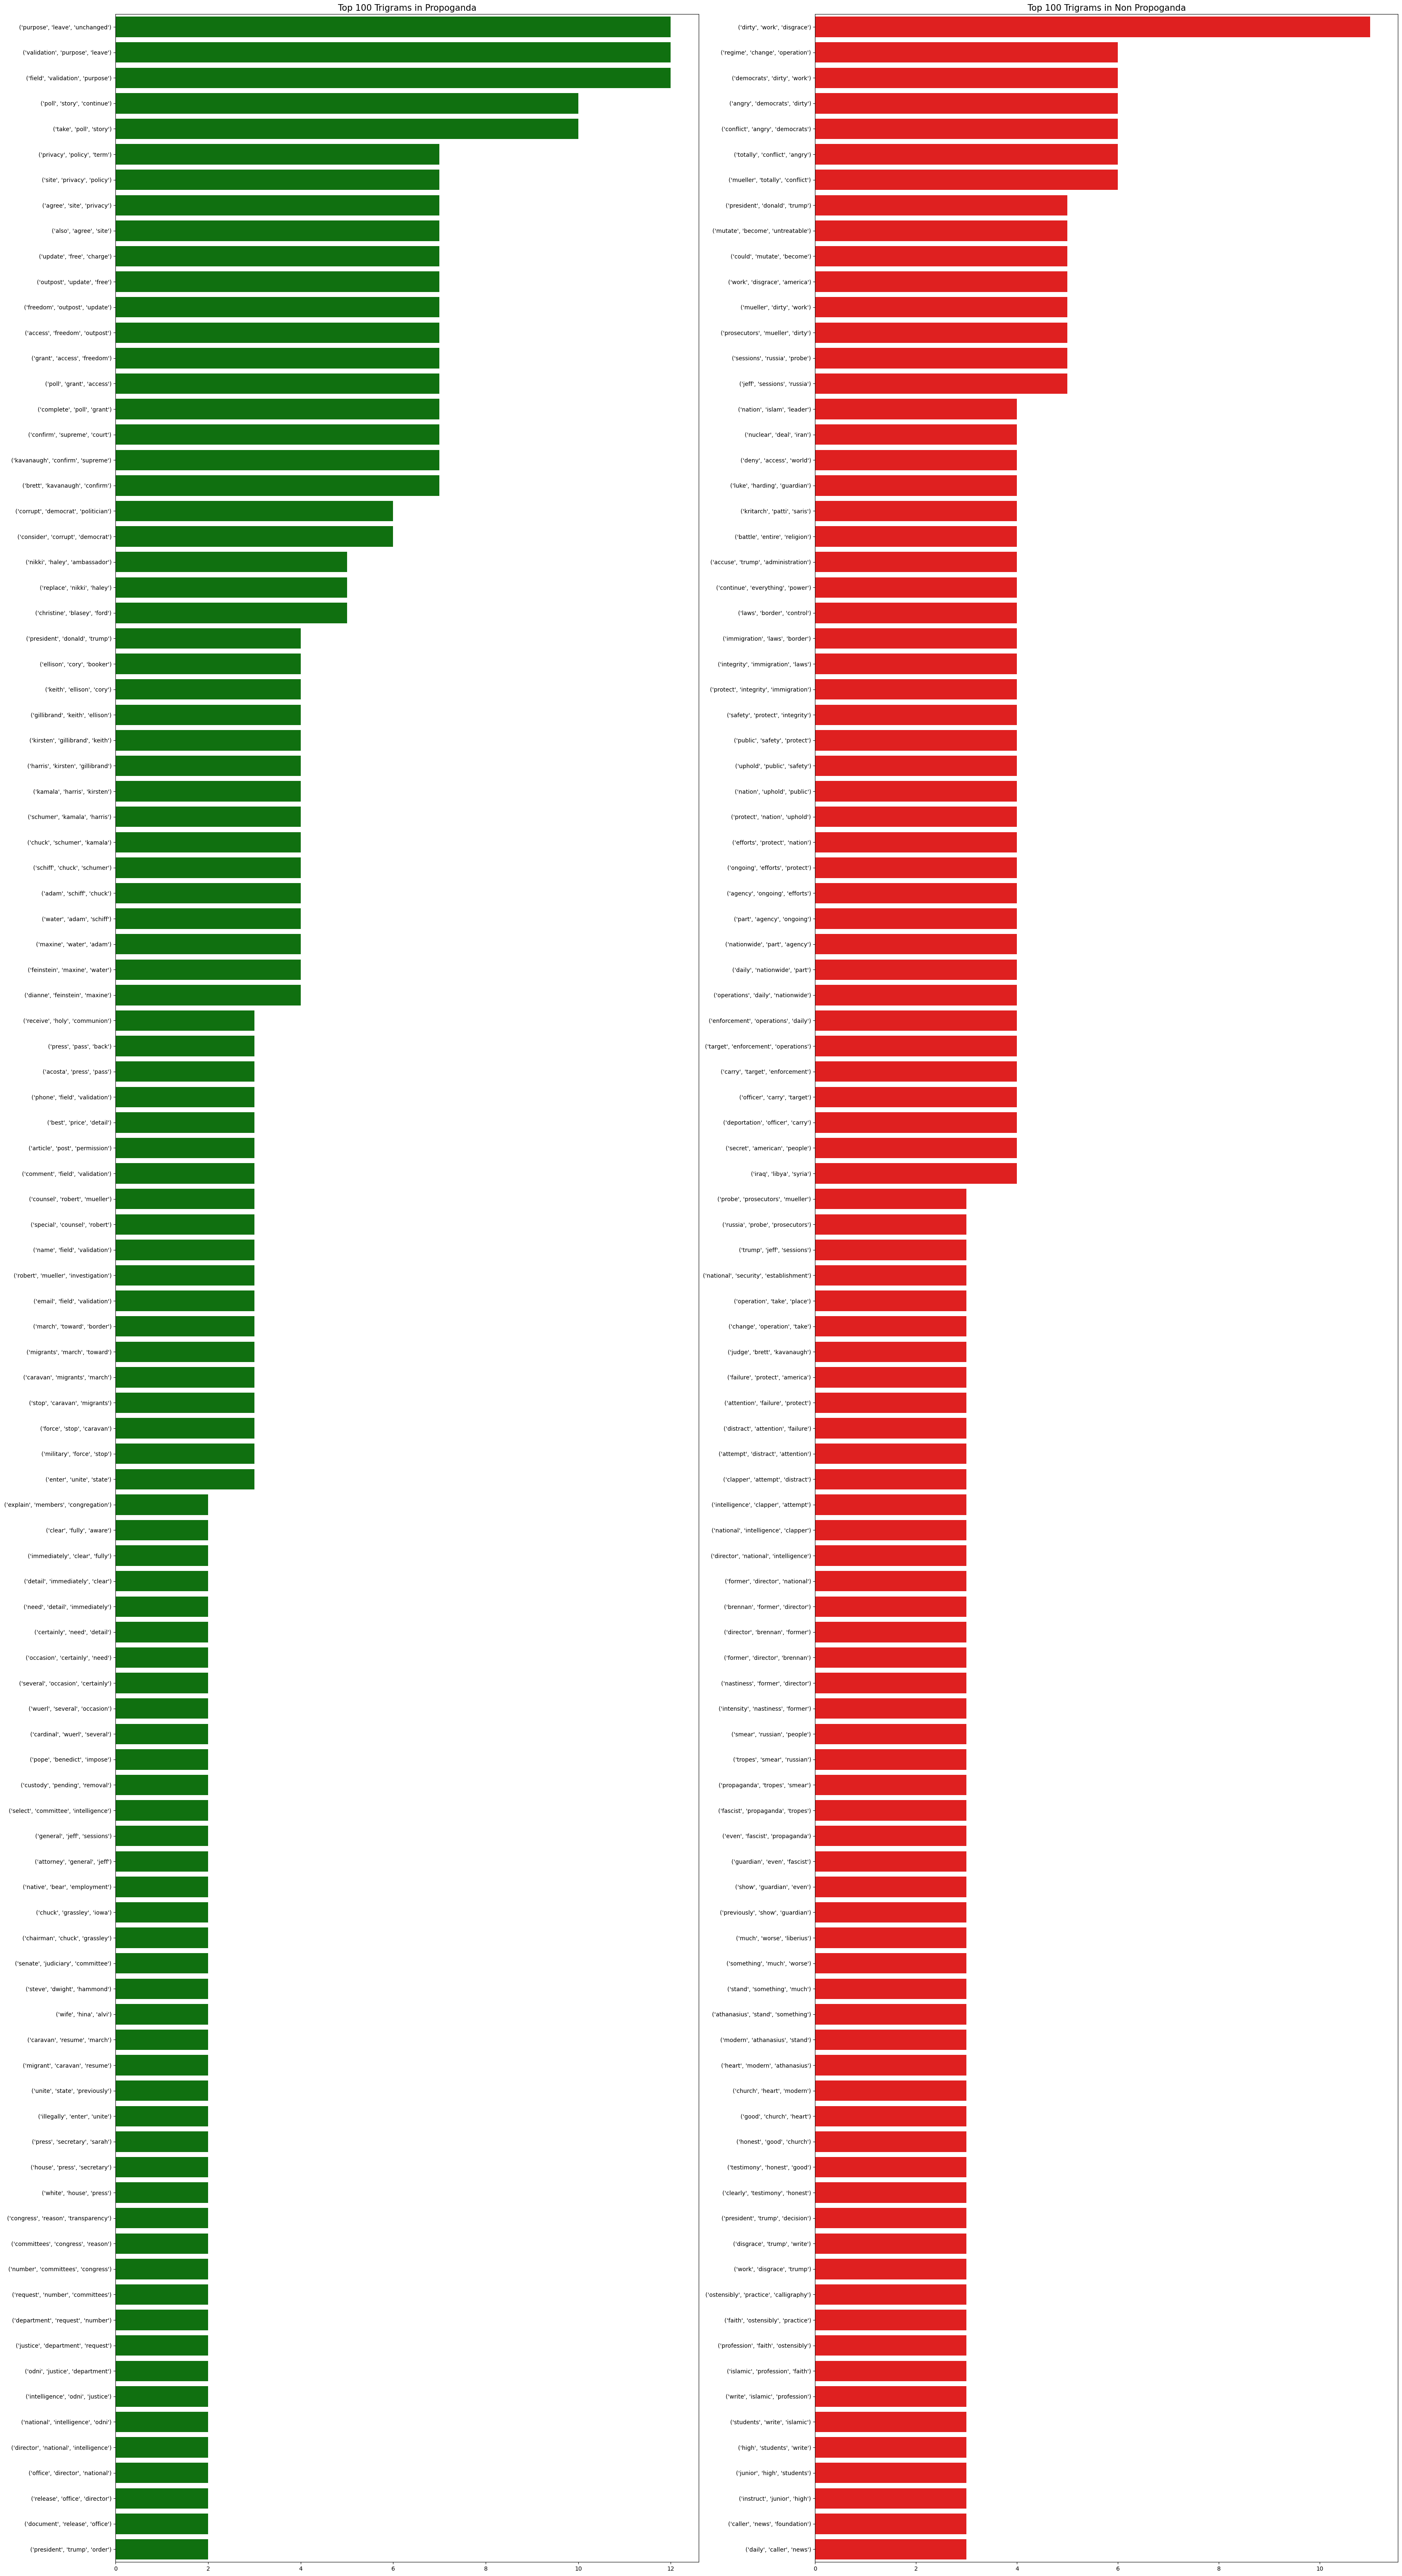

In [115]:
draw_barplots(propoganda_trigrams,non_propoganda_trigrams," Trigrams ")

In [117]:
#This function will show the word cloud of the propoganda 
def word_cloud(df):
    comment_words = ''
    stopwords = set(STOPWORDS)

    # iterate through the csv file
    for val in df.data:

        # typecaste each val to string
        val = str(val)

        # split the value
        tokens = val.split()

        for i in range(len(tokens)):
            tokens[i] = tokens[i].lower()

        comment_words += " ".join(tokens)+" "
        #return comment_words

    wordcloud = WordCloud(width = 800, height = 800,
            background_color ='white',
            stopwords = stopwords,
            min_font_size = 10).generate(comment_words)

    # plot the WordCloud image
    plt.figure(figsize = (8, 8), facecolor = None)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.tight_layout(pad = 0)
    plt.show()

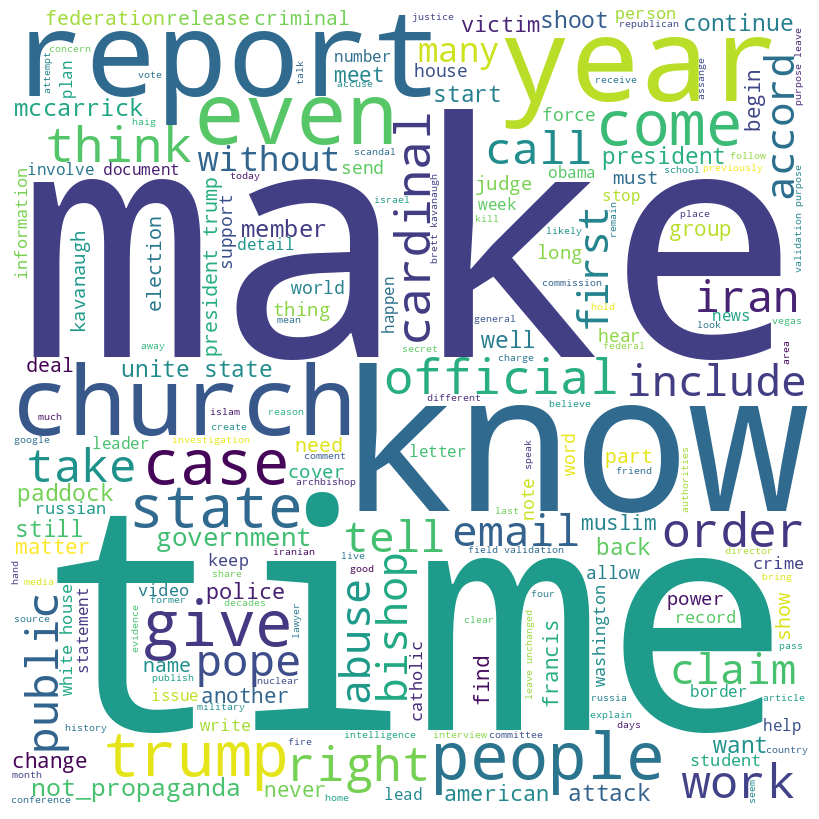

In [118]:
word_cloud(propoganda)

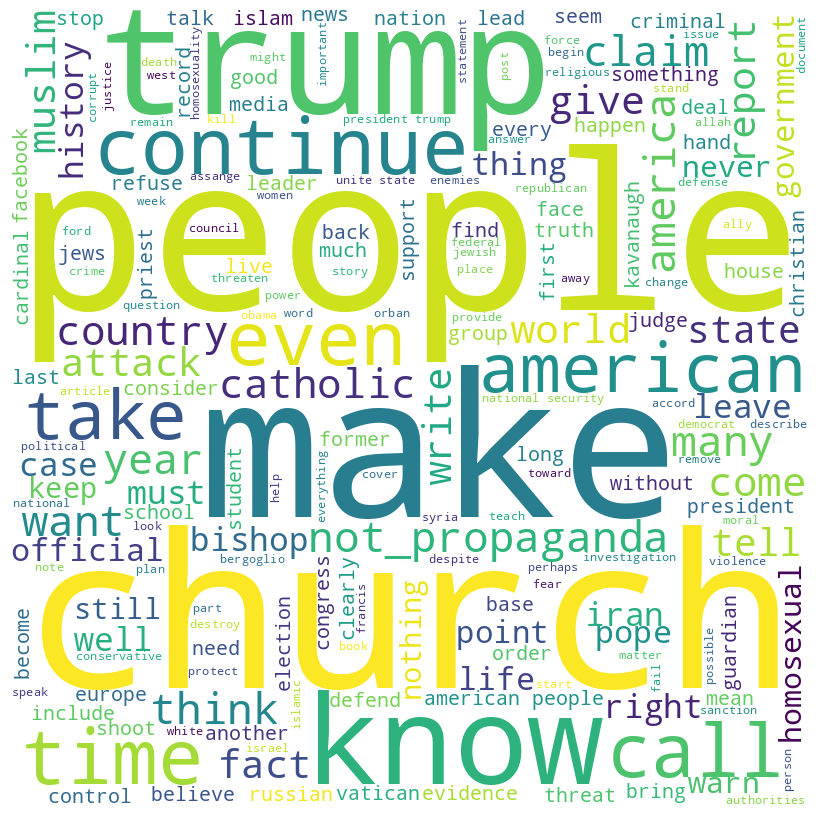

In [119]:
#This function will show the word cloud of the not_propoganda 
word_cloud(not_propoganda)

In [52]:
x_train = train['data']
y_train = train['target']
x_test  = val['data']
y_test = val['target']

In [53]:
# Bag of Words model
from keras.preprocessing.text import Tokenizer

# fit a tokenizer to tokenize the whole text.
def create_tokenizer(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [54]:
tokenizer = create_tokenizer(x_train)
tokenizer1 = create_tokenizer(x_test)
X_test_set = tokenizer.texts_to_matrix(x_test)
X_train_set = tokenizer.texts_to_matrix(x_train, mode = 'freq')

In [55]:
print(X_train_set.shape)
print(X_test_set.shape)

(2402, 9503)
(580, 9503)


In [56]:
# these function will show the evaluation metrices of f1 score and other
import tensorflow as tf
optimizer = tf.keras.optimizers.legacy.Adam(lr=0.001, epsilon=1e-08, decay=0.01)
import keras.backend as K
def specificity(y_true, y_pred):
    true_negatives = K.sum(K.round(K.clip((1 - y_true) * (1 - y_pred), 0, 1)))
    possible_negatives = K.sum(K.round(K.clip(1 - y_true, 0, 1)))
    return true_negatives / (possible_negatives + K.epsilon())
def sensitivity(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    return true_positives / (possible_positives + K.epsilon())
def F1_Score(y_true, y_pred): #taken from old keras source code
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    recall = true_positives / (possible_positives + K.epsilon())
    f1_val = 2*(precision*recall)/(precision+recall+K.epsilon())
    return f1_val
metrics=[tf.keras.metrics.AUC(num_thresholds=200,curve='ROC',summation_method='interpolation',name=None,dtype=None,thresholds=None,multi_label=False,num_labels=None,label_weights=None,from_logits=False),
                         tf.keras.metrics.Precision(),tf.keras.metrics.Recall(),'accuracy',
                   specificity ,sensitivity,F1_Score]

/usr/local/lib/python3.10/dist-packages/keras/optimizers/legacy/adam.py:117: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super().__init__(name, **kwargs)


In [57]:
# define the model of simle ANN
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(128, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics = metrics)
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

In [58]:
n_words = X_train_set.shape[1]
model = define_model(n_words)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               1216512   
                                                                 
 dense_4 (Dense)             (None, 1)                 129       
                                                                 
Total params: 1,216,641
Trainable params: 1,216,641
Non-trainable params: 0
_________________________________________________________________


In [59]:
model.fit(X_train_set,y_train,validation_data = (X_test_set,y_test),epochs=10,verbose=2)

Epoch 1/10
76/76 - 3s - loss: 0.6872 - auc_1: 0.6313 - precision_1: 0.6382 - recall_1: 0.4283 - accuracy: 0.5978 - specificity: 0.7648 - sensitivity: 0.4231 - F1_Score: 0.4355 - val_loss: 0.5783 - val_auc_1: 0.7835 - val_precision_1: 0.7077 - val_recall_1: 0.7641 - val_accuracy: 0.7138 - val_specificity: 0.6786 - val_sensitivity: 0.7743 - val_F1_Score: 0.7450 - 3s/epoch - 45ms/step
Epoch 2/10
76/76 - 0s - loss: 0.6491 - auc_1: 0.8413 - precision_1: 0.8392 - recall_1: 0.5852 - accuracy: 0.7398 - specificity: 0.8833 - sensitivity: 0.5849 - F1_Score: 0.6701 - val_loss: 0.7533 - val_auc_1: 0.7910 - val_precision_1: 0.6975 - val_recall_1: 0.8272 - val_accuracy: 0.7241 - val_specificity: 0.6362 - val_sensitivity: 0.8361 - val_F1_Score: 0.7663 - 418ms/epoch - 5ms/step
Epoch 3/10
76/76 - 0s - loss: 0.5759 - auc_1: 0.8974 - precision_1: 0.8531 - recall_1: 0.7049 - accuracy: 0.7943 - specificity: 0.8851 - sensitivity: 0.7007 - F1_Score: 0.7580 - val_loss: 1.3140 - val_auc_1: 0.7839 - val_precisi

In [60]:
#testing on test data
y_pred = model.predict(X_test_set)

19/19 [==============================] - 0s 2ms/step


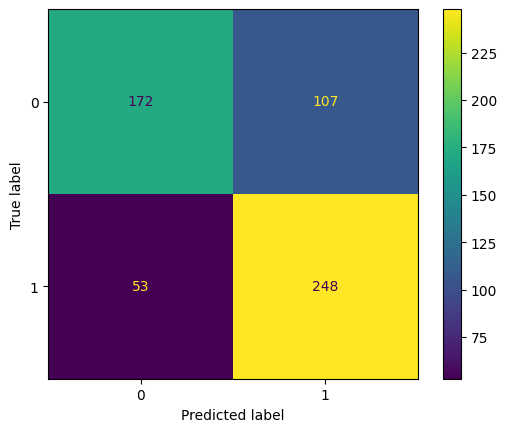

In [61]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
#Cinfusion metrix
cm = confusion_matrix(y_test, np.round(abs(y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [62]:
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
#lstm with embedding layer

In [64]:
embed_dim = 128
lstm_out = 196

model = Sequential()
model.add(Embedding(512, embed_dim,input_length = X_train_set.shape[1]))
model.add(LSTM(lstm_out, dropout=0.4, recurrent_dropout=0.4))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss = 'binary_crossentropy', optimizer='Adam', metrics = metrics)
print(model.summary())

In [67]:
X_train_set.shape[1]

9503

In [ ]:
#below this you have to run .it will take time

In [ ]:
model.fit(X_train_set,y_train,epochs = 5)

In [ ]:
y_pred = model.predict(X_test_set)


In [ ]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, np.round(abs(y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()

In [ ]:
### Add tokens to the data make it BERT compatible make it for model inputs
def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []

    for text in texts:
        text = tokenizer.tokenize(text)

        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)

        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len

        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)

    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [ ]:
from keras.layers import Input
from tensorflow.keras import Model
import tensorflow as tf

In [ ]:
def build_model(bert_layer, max_len=512):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)

    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(tf.keras.optimizers.Adam(lr=2e-6), loss='binary_crossentropy', metrics=metrics)

    return model

In [ ]:
!pip install bert-tensorflow

In [ ]:
import tensorflow_hub as hub
import bert
from bert import tokenization

In [1]:
#loading model and other supporting meterials from hub

In [ ]:
m_url = 'https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2'
bert_layer = hub.KerasLayer(m_url, trainable=True)#bert layer 

In [ ]:
#Vocab file
vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()

In [ ]:
import nltk
nltk.download("punkt")

In [ ]:
#Bert toekinizer
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [ ]:
import sys
from absl import flags
sys.argv=['preserve_unused_tokens=False']
flags.FLAGS(sys.argv)

In [ ]:
#encoding the features and target values
train_input = bert_encode(train.data.values, tokenizer, max_len=160)
train_labels = train.target.values

In [ ]:
#building bert model
model = build_model(bert_layer, max_len=160)
model.summary()

In [ ]:
#training bert model
train_history = model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=3,
    batch_size=16
)

In [ ]:
#taking inouts aand target
train_input = bert_encode(val.data.values, tokenizer, max_len=160)

In [ ]:
#Confusion metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
y_pred = model.predict(train_input)
y_test = val.target.values
cm = confusion_matrix(y_test, np.round(abs(y_pred)))
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()